# Vehicle Telematics Analysis

## 1. Data Sanity Checks
- Load TLM, TRG, MAP, SYN
- Validate timestamps, units, joins

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import ast
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
import json
from datetime import datetime, timedelta

# Load CSVs
tlm = pd.read_csv('file:///Users/pushkalgupta/Desktop/ds_assement_2026_summer_intern_CE/Motorq%20Data%20Science%20Assignment%20-%202024/telemetry_data.csv')
trg = pd.read_csv('file:///Users/pushkalgupta/Desktop/ds_assement_2026_summer_intern_CE/Motorq%20Data%20Science%20Assignment%20-%202024/triggers_soc.csv')
map_df = pd.read_csv('file:///Users/pushkalgupta/Desktop/ds_assement_2026_summer_intern_CE/Motorq%20Data%20Science%20Assignment%20-%202024/vehicle_pnid_mapping.csv')

#Load JSON

# Path to SYN JSON
syn_path = '/Users/pushkalgupta/Desktop/ds_assement_2026_summer_intern_CE/Motorq Data Science Assignment - 2024/artificial_ign_off_data.json'

# Load SYN
try:
    with open(syn_path, 'r') as f:
        syn = json.load(f)
    syn_df = pd.json_normalize(syn)  # Flatten JSON if nested
    print("SYN loaded successfully\n")
except FileNotFoundError:
    print("SYN file not found. Proceeding without it.")
    syn_df = None

SYN loaded successfully



- Now we have 4 datasets all as dataframes in pandas
- Let's see what data we have
- Let us understand the data first

In [7]:
trg['Val'].as
rows = trg[(trg.val.astypes('float')>100)]

AttributeError: 'DataFrame' object has no attribute 'val'

In [2]:
print("=== TLM Data ===")
print(f"Shape: {tlm.shape}")  # (rows, columns)
print("\nFirst 5 rows:")
display(tlm.head())
print("\nLast 5 rows:")
display(tlm.tail())
print("\nColumn info:")
display(tlm.info())
print("\nMissing values:")
display(tlm.isnull().sum())

=== TLM Data ===
Shape: (1833552, 8)

First 5 rows:


,Unnamed: 0,ID,VEHICLE_ID,TIMESTAMP,SPEED,IGNITION_STATUS,EV_BATTERY_LEVEL,ODOMETER
0,0,428bdd3a-243a-4735-b3be-4e12ec511774,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:45:42.018,NaN,NaN,NaN,NaN
1,1,b76e490b-8292-4b20-927c-5842bda6104a,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:58:08.017,NaN,NaN,NaN,NaN
2,2,40aabc8e-5a83-4772-bbd6-1d2634f20aa4,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:57:02.031,NaN,NaN,NaN,38685.9
3,3,8f73a942-e549-4662-9f7e-e21f3d104637,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:38:57.002,0.0,on,NaN,NaN
4,4,852caadc-e582-4cd0-97cb-7f9a20c9634f,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 02:00:05.004,NaN,NaN,NaN,NaN



Last 5 rows:


,Unnamed: 0,ID,VEHICLE_ID,TIMESTAMP,SPEED,IGNITION_STATUS,EV_BATTERY_LEVEL,ODOMETER
1833547,1833547,1c3993d7-950f-403a-b28a-b18b578c6d42,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-16 19:00:44.031,NaN,NaN,NaN,37806.4
1833548,1833548,ad4c3e03-2da2-4df5-89d1-342b40c52bf4,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-10-04 18:14:26.004,NaN,NaN,NaN,40197.9
1833549,1833549,a41be545-3a76-4ff7-96d6-199129bb58cf,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2022-01-27 16:14:10.007,NaN,NaN,NaN,NaN
1833550,1833550,09cedd28-2f61-4dc0-9fcd-265472432930,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-11-15 15:33:01.346,32.9,on,NaN,NaN
1833551,1833551,5d31b21c-b877-4daa-9f1c-0115cf5770eb,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,2023-01-24 17:09:07.009000,NaN,NaN,NaN,NaN



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833552 entries, 0 to 1833551
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   ID                object 
 2   VEHICLE_ID        object 
 3   TIMESTAMP         object 
 4   SPEED             float64
 5   IGNITION_STATUS   object 
 6   EV_BATTERY_LEVEL  float64
 7   ODOMETER          float64
dtypes: float64(3), int64(1), object(4)
memory usage: 111.9+ MB


None


Missing values:


Unnamed: 0                0
ID                        0
VEHICLE_ID                0
TIMESTAMP                 0
SPEED               1481783
IGNITION_STATUS     1604060
EV_BATTERY_LEVEL    1444149
ODOMETER            1349553
dtype: int64

### Checks:
- Are timestamps parsed correctly? (Check dtype for TIMESTAMP).
- Are there missing values in critical fields (IGNITION_STATUS, EV_BATTERY_LEVEL)?
- Are there unrealistic values (e.g., battery % > 100)?

In [3]:
print("\n=== TRG Data ===")
print(f"Shape: {trg.shape}")
print("\nFirst 5 rows:")
display(trg.head())
print("\nLast 5 rows:")
display(trg.tail())
print("\nUnique event names (NAME column):")
display(trg['NAME'].unique())
print("\nValue counts for CHARGE_STATE (if exists):")
if 'CHARGE_STATE' in trg['NAME'].unique():
    display(trg[trg['NAME'] == 'CHARGE_STATE']['VAL'].value_counts())


=== TRG Data ===
Shape: (68670, 5)

First 5 rows:


,Unnamed: 0,CTS,PNID,NAME,VAL
0,0,2021-12-01 17:58:27 IST+0530,206958332,IGN_CYL,OFF
1,1,2021-12-01 17:58:27 IST+0530,206958332,IGN_CYL,OFF
2,2,2021-12-01 17:56:24 IST+0530,206958332,IGN_CYL,ON
3,3,2021-12-01 17:56:24 IST+0530,206958332,CHARGE_STATE,50.1
4,4,2021-12-01 17:56:24 IST+0530,206958332,IGN_CYL,ON



Last 5 rows:


,Unnamed: 0,CTS,PNID,NAME,VAL
68665,68665,2022-01-28 20:45:07 IST+0530,193290358,IGN_CYL,OFF
68666,68666,2022-01-28 20:45:52 IST+0530,207925262,IGN_CYL,ON
68667,68667,2022-01-28 20:45:52 IST+0530,207925262,CHARGE_STATE,49.0
68668,68668,2022-01-28 20:45:52 IST+0530,207925262,IGN_CYL,ON
68669,68669,2022-01-28 20:45:52 IST+0530,207925262,CHARGE_STATE,49.0



Unique event names (NAME column):


array(['IGN_CYL', 'CHARGE_STATE', 'EV_CHARGE_STATE'], dtype=object)


Value counts for CHARGE_STATE (if exists):


94.5     339
100.0    335
71.7     318
67.0     263
79.2     260
        ... 
4.3        6
3.1        4
1.9        3
5.0        3
0.7        1
Name: VAL, Length: 256, dtype: int64

### Checks
- Are critical events (IGN_CYCL, CHARGE_STATE) present?
- What values do they take? (e.g., VAL=1 might mean "charging active").

In [4]:
print("\n=== MAP Data ===")
print(f"Shape: {map_df.shape}")
print("\nFirst 5 rows:")
display(map_df.head())
print("\nLast 5 rows:")
display(map_df.tail())
print("\nUnique vehicle IDs vs PNIDs:")
print(f"Vehicles: {map_df['ID'].nunique()}, PNIDs: {map_df['IDS'].nunique()}")


=== MAP Data ===
Shape: (19, 3)

First 5 rows:


,Unnamed: 0,ID,IDS
0,0,66bd55df-eaf0-49c8-b9e1-7759b85e9325,"[\n ""256932585"",\n ""256932577"",\n ""25693258..."
1,1,ae912623-e122-4bfb-b2a1-7d407ea42b1b,NaN
2,2,39424065-b3be-45e5-8f7d-b7f16a6c190a,NaN
3,3,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,"[\n ""270199389"",\n ""270199393"",\n ""27019938..."
4,0,9893c80d-f282-46cf-a794-280f0306c936,"[\n ""256933093"",\n ""256933081"",\n ""25693308..."



Last 5 rows:


,Unnamed: 0,ID,IDS
14,10,9eb5ac45-bbf9-4a07-83d8-044372f336c7,"[\n ""255131120"",\n ""255131128"",\n ""25513113..."
15,11,ef67f6d6-196a-4bc0-94fa-c13ad9672dac,"[\n ""331750427"",\n ""331750431"",\n ""33175042..."
16,12,8ce8b281-3c5e-4b17-a863-630b9fc813dc,"[\n ""248102116"",\n ""248102132"",\n ""24810212..."
17,13,807158a9-c266-4cda-b061-e76314b1b422,"[\n ""248503362"",\n ""248503574"",\n ""24850336..."
18,14,04105a12-59b9-447b-865f-599f48eed1d7,"[\n ""331750387"",\n ""331750395"",\n ""33175039..."



Unique vehicle IDs vs PNIDs:
Vehicles: 16, PNIDs: 13


### Checks
- Are there 1:1 mappings, or can one vehicle have multiple PNIDs?
- Are there missing mappings?

In [5]:
print("\n=== SYN Data ===")
if syn_df is not None:
    print(f"Shape: {syn_df.shape}")
    print("\nFirst 5 rows:")
    display(syn_df.head())
    print("\nLast 5 rows:")
    display(syn_df.tail())
    print("\nEvent type counts:")
    display(syn_df['type'].value_counts())
else:
    print("SYN file not loaded.")


=== SYN Data ===
Shape: (411, 3)

First 5 rows:


,vehicleId,timestamp,type
0,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2022-01-31T19:13:06.001Z,artificial_event
1,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2022-01-31T04:25:05.011Z,artificial_event
2,460a67ab-ee58-4279-b96d-ac56ac029d3e,2022-01-30T01:58:57.004Z,artificial_event
3,9893c80d-f282-46cf-a794-280f0306c936,2022-01-30T21:43:42.027Z,artificial_event
4,fb20e847-d2a1-4583-b874-393c9d1f3db9,2022-01-31T04:25:05.038Z,artificial_event



Last 5 rows:


,vehicleId,timestamp,type
406,f0704100-56e6-4117-ae4f-cf97e5d2d132,2021-12-19T07:32:14.004Z,artificial_event
407,fb20e847-d2a1-4583-b874-393c9d1f3db9,2021-12-19T05:54:05.037Z,artificial_event
408,fb20e847-d2a1-4583-b874-393c9d1f3db9,2021-12-19T04:10:51.041Z,artificial_event
409,460a67ab-ee58-4279-b96d-ac56ac029d3e,2021-12-18T22:45:17.030Z,artificial_event
410,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2021-12-18T18:53:37.067Z,artificial_event



Event type counts:


artificial_event    411
Name: type, dtype: int64

### Checks
- Are timestamps parsed correctly?
- Do all entries align with TLM/TRG vehicles?

# Summary of Understanding

Telemetry Data (TLM)
This is our classic dataset of vehicles which includes columns like ignition status, speed, and battery level.
We can use this to detect delta(ignition) and delta(battery)
The particular moment or instance when we capture data has been mentioned in the timestamp.

Triggers Data (TRG)
Low-frequency logs recording name/value events like ignition cycles and charge states.
Key source for detecting charging status transitions and ignition events.

Mapping Data (MAP)
This is like a transition table or a map that helps to connect between the datasets, to understand them better.
It provides kind of a mapping between TLM VEHICLE_ID and TRG PNID.
A linking between internal and external ids.

 Synthetic Overrides (SYN)
These basically mean that the sensor doesn't say whether the ignition of the car is on or off, but as a human we know in certain cases that it certainly isn't on, so these have been added in SYN.

# Key Findings

### TLM (Telemetry Data)
- Timestamp Issues:
TIMESTAMP is stored as strings (needs conversion to datetime)
- Contains data from 2021-09-16 to 2023-01-24 (wide date range)
##### Data Quality:

- High percentage of missing values:
- 87.5% missing IGNITION_STATUS (1,604,060/1,833,552)
- 78.8% missing EV_BATTERY_LEVEL
- 80.8% missing SPEED
- Maybe Just Maybe can use this for event detection
- 
__This is due to different polling rates of each sensor__

Some rows have all critical fields missing (first 2 rows as an example)

###### Ignition Status:
When present, shows values like "on"/"off" (needs standardization)(probably a dummy can be created, to do ign_on, and ign_off having 0 or 1 values)

### TRG (Triggers Data)
###### Event Types:
- Contains IGN_CYL (ignition cycles) and CHARGE_STATE events
- CHARGE_STATE values range from 0.7 to 100.0 (battery percentages)

###### Timestamp Format:

- CTS uses IST timezone (needs UTC conversion for consistency, as TLM are UTC) - mentioned as clock drift

###### Data Quality:
- Appears more complete than TLM for critical events
- Contains duplicate events (same timestamp, same values)

### MAP (Mapping Data)
###### Vehicle-PNID Relationship:

- 16 unique vehicles, 13 have PNID mappings
- Some vehicles have multiple PNIDs (5-18 per vehicle)
- 3 vehicles have no PNIDs (will be unable to match their TRG events)

##### Data Structure:
- IDS stored as JSON strings (needs parsing)

### SYN (Synthetic Data)
- Contains 200 artificial ignition-off events (already loaded successfully)/

# Issues to Fix

##### TLM Data Quality:
- Extremely sparse ignition and battery data (may not be reliable as primary source)
- Need to rely more on TRG for event detection

##### Time Zone Inconsistency:
- TLM timestamps appear UTC-like
- TRG timestamps explicitly marked as IST (+0530)

###### Mapping Gaps:
- 3 vehicles won't have TRG data available
- Some PNIDs may not map to any vehicle

# Data Cleaning

##### Time Normalization

In [6]:
# Convert TLM timestamps
tlm['TIMESTAMP'] = pd.to_datetime(tlm['TIMESTAMP'])

# Convert TRG timestamps (handle IST timezone)
trg['CTS'] = pd.to_datetime(trg['CTS']).dt.tz_convert('UTC')

##### Parsing for mapping into python lists

In [7]:
# Parse MAP's IDS field
import ast
map_df['PNIDs'] = map_df['IDS'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

##### Issues getting fixed
- Makes ignition values consistent for analysis
- Unrolls PNID lists so each mapping is easy to join
- Cleans TRG event values for logic
- A debug log is always helpful to look at

In [8]:
# 1. Standardize ignition status in TLM (convert to binary 1/0)
tlm['IGNITION_STATUS'] = tlm['IGNITION_STATUS'].map({'on': 1, 'off': 0, 'ON': 1, 'OFF': 0})

# 2. Create exploded mapping table (vehicle_id to all PNIDs)
mapping_table = map_df.explode('PNIDs')[['ID', 'PNIDs']].dropna()
mapping_table.columns = ['VEHICLE_ID', 'PNID']

# 3. Clean TRG data - standardize event values
trg['VAL'] = trg['VAL'].replace({'ON': 1, 'OFF': 0, 'on': 1, 'off': 0})

# Document anomalies found
print("\n=== Data Anomalies ===")
print(f"- {tlm['IGNITION_STATUS'].isna().sum()} missing ignition statuses in TLM")
print(f"- {len(map_df[map_df['IDS'].isna()])} vehicles with no PNID mapping")
print(f"- {trg.duplicated().sum()} duplicate rows in TRG data")


=== Data Anomalies ===
- 1605260 missing ignition statuses in TLM
- 6 vehicles with no PNID mapping
- 0 duplicate rows in TRG data


##### Clock Drift Issues fix

In [9]:
# Handle clock drift by ensuring all timestamps are in UTC (FIXED VERSION)

# --- TLM: TIMESTAMP column ---
tlm['TIMESTAMP'] = pd.to_datetime(tlm['TIMESTAMP'], errors='coerce')
if pd.api.types.is_datetime64tz_dtype(tlm['TIMESTAMP']):
    # Already timezone-aware → convert to UTC
    tlm['TIMESTAMP'] = tlm['TIMESTAMP'].dt.tz_convert('UTC')
else:
    # Naive datetime → localize to UTC
    tlm['TIMESTAMP'] = tlm['TIMESTAMP'].dt.tz_localize('UTC')

# --- TRG: CTS column (assumed to be in IST originally) ---
trg['CTS'] = pd.to_datetime(trg['CTS'], errors='coerce')
if pd.api.types.is_datetime64tz_dtype(trg['CTS']):
    trg['CTS'] = trg['CTS'].dt.tz_convert('UTC')
else:
    # First localize to IST, then convert to UTC
    trg['CTS'] = trg['CTS'].dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')

# --- SYN: timestamp column ---
if syn_df is not None and 'timestamp' in syn_df.columns:
    syn_df['timestamp'] = pd.to_datetime(syn_df['timestamp'], errors='coerce')
    if pd.api.types.is_datetime64tz_dtype(syn_df['timestamp']):
        syn_df['timestamp'] = syn_df['timestamp'].dt.tz_convert('UTC')
    else:
        syn_df['timestamp'] = syn_df['timestamp'].dt.tz_localize('UTC')


### Data Inspection

In [10]:
print("=== TLM Data ===")
print(f"Shape: {tlm.shape}")  # (rows, columns)
print("\nFirst 5 rows:")
display(tlm.head())
print("\nLast 5 rows:")
display(tlm.tail())
print("\nColumn info:")
display(tlm.info())
print("\nMissing values:")
display(tlm.isnull().sum())
print("\n=== TRG Data ===")
print(f"Shape: {trg.shape}")
print("\nFirst 5 rows:")
display(trg.head())
print("\nLast 5 rows:")
display(trg.tail())
print("\nUnique event names (NAME column):")
display(trg['NAME'].unique())
print("\nValue counts for CHARGE_STATE (if exists):")
if 'CHARGE_STATE' in trg['NAME'].unique():
    display(trg[trg['NAME'] == 'CHARGE_STATE']['VAL'].value_counts())
print("\n=== MAP Data ===")
print(f"Shape: {map_df.shape}")
print("\nFirst 5 rows:")
display(map_df.head())
print("\nLast 5 rows:")
display(map_df.tail())
print("\nUnique vehicle IDs vs PNIDs:")
print(f"Vehicles: {map_df['ID'].nunique()}, PNIDs: {map_df['IDS'].nunique()}")
print("\n=== SYN Data ===")
print(f"Shape: {syn_df.shape}")
print("\nFirst 5 rows:")
display(syn_df.head())
print("\nLast 5 rows:")
display(syn_df.tail())
print("\nEvent type counts:")
display(syn_df['type'].value_counts())

=== TLM Data ===
Shape: (1833552, 8)

First 5 rows:


,Unnamed: 0,ID,VEHICLE_ID,TIMESTAMP,SPEED,IGNITION_STATUS,EV_BATTERY_LEVEL,ODOMETER
0,0,428bdd3a-243a-4735-b3be-4e12ec511774,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:45:42.018000+00:00,NaN,NaN,NaN,NaN
1,1,b76e490b-8292-4b20-927c-5842bda6104a,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:58:08.017000+00:00,NaN,NaN,NaN,NaN
2,2,40aabc8e-5a83-4772-bbd6-1d2634f20aa4,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:57:02.031000+00:00,NaN,NaN,NaN,38685.9
3,3,8f73a942-e549-4662-9f7e-e21f3d104637,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 01:38:57.002000+00:00,0.0,1.0,NaN,NaN
4,4,852caadc-e582-4cd0-97cb-7f9a20c9634f,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-23 02:00:05.004000+00:00,NaN,NaN,NaN,NaN



Last 5 rows:


,Unnamed: 0,ID,VEHICLE_ID,TIMESTAMP,SPEED,IGNITION_STATUS,EV_BATTERY_LEVEL,ODOMETER
1833547,1833547,1c3993d7-950f-403a-b28a-b18b578c6d42,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-09-16 19:00:44.031000+00:00,NaN,NaN,NaN,37806.4
1833548,1833548,ad4c3e03-2da2-4df5-89d1-342b40c52bf4,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-10-04 18:14:26.004000+00:00,NaN,NaN,NaN,40197.9
1833549,1833549,a41be545-3a76-4ff7-96d6-199129bb58cf,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2022-01-27 16:14:10.007000+00:00,NaN,NaN,NaN,NaN
1833550,1833550,09cedd28-2f61-4dc0-9fcd-265472432930,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-11-15 15:33:01.346000+00:00,32.9,1.0,NaN,NaN
1833551,1833551,5d31b21c-b877-4daa-9f1c-0115cf5770eb,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,2023-01-24 17:09:07.009000+00:00,NaN,NaN,NaN,NaN



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833552 entries, 0 to 1833551
Data columns (total 8 columns):
 #   Column            Dtype              
---  ------            -----              
 0   Unnamed: 0        int64              
 1   ID                object             
 2   VEHICLE_ID        object             
 3   TIMESTAMP         datetime64[ns, UTC]
 4   SPEED             float64            
 5   IGNITION_STATUS   float64            
 6   EV_BATTERY_LEVEL  float64            
 7   ODOMETER          float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 111.9+ MB


None


Missing values:


Unnamed: 0                0
ID                        0
VEHICLE_ID                0
TIMESTAMP                 0
SPEED               1481783
IGNITION_STATUS     1605260
EV_BATTERY_LEVEL    1444149
ODOMETER            1349553
dtype: int64


=== TRG Data ===
Shape: (68670, 5)

First 5 rows:


,Unnamed: 0,CTS,PNID,NAME,VAL
0,0,2021-12-01 12:28:27+00:00,206958332,IGN_CYL,0
1,1,2021-12-01 12:28:27+00:00,206958332,IGN_CYL,0
2,2,2021-12-01 12:26:24+00:00,206958332,IGN_CYL,1
3,3,2021-12-01 12:26:24+00:00,206958332,CHARGE_STATE,50.1
4,4,2021-12-01 12:26:24+00:00,206958332,IGN_CYL,1



Last 5 rows:


,Unnamed: 0,CTS,PNID,NAME,VAL
68665,68665,2022-01-28 15:15:07+00:00,193290358,IGN_CYL,0
68666,68666,2022-01-28 15:15:52+00:00,207925262,IGN_CYL,1
68667,68667,2022-01-28 15:15:52+00:00,207925262,CHARGE_STATE,49.0
68668,68668,2022-01-28 15:15:52+00:00,207925262,IGN_CYL,1
68669,68669,2022-01-28 15:15:52+00:00,207925262,CHARGE_STATE,49.0



Unique event names (NAME column):


array(['IGN_CYL', 'CHARGE_STATE', 'EV_CHARGE_STATE'], dtype=object)


Value counts for CHARGE_STATE (if exists):


94.5     339
100.0    335
71.7     318
67.0     263
79.2     260
        ... 
4.3        6
3.1        4
1.9        3
5.0        3
0.7        1
Name: VAL, Length: 256, dtype: int64


=== MAP Data ===
Shape: (19, 4)

First 5 rows:


,Unnamed: 0,ID,IDS,PNIDs
0,0,66bd55df-eaf0-49c8-b9e1-7759b85e9325,"[\n ""256932585"",\n ""256932577"",\n ""25693258...","[256932585, 256932577, 256932581, 256932589, 2..."
1,1,ae912623-e122-4bfb-b2a1-7d407ea42b1b,NaN,[]
2,2,39424065-b3be-45e5-8f7d-b7f16a6c190a,NaN,[]
3,3,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,"[\n ""270199389"",\n ""270199393"",\n ""27019938...","[270199389, 270199393, 270199385, 270199397, 2..."
4,0,9893c80d-f282-46cf-a794-280f0306c936,"[\n ""256933093"",\n ""256933081"",\n ""25693308...","[256933093, 256933081, 256933085, 256933089, 2..."



Last 5 rows:


,Unnamed: 0,ID,IDS,PNIDs
14,10,9eb5ac45-bbf9-4a07-83d8-044372f336c7,"[\n ""255131120"",\n ""255131128"",\n ""25513113...","[255131120, 255131128, 255131132, 255131116, 2..."
15,11,ef67f6d6-196a-4bc0-94fa-c13ad9672dac,"[\n ""331750427"",\n ""331750431"",\n ""33175042...","[331750427, 331750431, 331750423, 331750535, 3..."
16,12,8ce8b281-3c5e-4b17-a863-630b9fc813dc,"[\n ""248102116"",\n ""248102132"",\n ""24810212...","[248102116, 248102132, 248102124, 248102128, 2..."
17,13,807158a9-c266-4cda-b061-e76314b1b422,"[\n ""248503362"",\n ""248503574"",\n ""24850336...","[248503362, 248503574, 248503366, 248503570, 2..."
18,14,04105a12-59b9-447b-865f-599f48eed1d7,"[\n ""331750387"",\n ""331750395"",\n ""33175039...","[331750387, 331750395, 331750391, 331750399, 3..."



Unique vehicle IDs vs PNIDs:
Vehicles: 16, PNIDs: 13

=== SYN Data ===
Shape: (411, 3)

First 5 rows:


,vehicleId,timestamp,type
0,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2022-01-31 19:13:06.001000+00:00,artificial_event
1,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2022-01-31 04:25:05.011000+00:00,artificial_event
2,460a67ab-ee58-4279-b96d-ac56ac029d3e,2022-01-30 01:58:57.004000+00:00,artificial_event
3,9893c80d-f282-46cf-a794-280f0306c936,2022-01-30 21:43:42.027000+00:00,artificial_event
4,fb20e847-d2a1-4583-b874-393c9d1f3db9,2022-01-31 04:25:05.038000+00:00,artificial_event



Last 5 rows:


,vehicleId,timestamp,type
406,f0704100-56e6-4117-ae4f-cf97e5d2d132,2021-12-19 07:32:14.004000+00:00,artificial_event
407,fb20e847-d2a1-4583-b874-393c9d1f3db9,2021-12-19 05:54:05.037000+00:00,artificial_event
408,fb20e847-d2a1-4583-b874-393c9d1f3db9,2021-12-19 04:10:51.041000+00:00,artificial_event
409,460a67ab-ee58-4279-b96d-ac56ac029d3e,2021-12-18 22:45:17.030000+00:00,artificial_event
410,3e937810-3a3b-48d6-80ad-56ae12c3bed8,2021-12-18 18:53:37.067000+00:00,artificial_event



Event type counts:


artificial_event    411
Name: type, dtype: int64

Non-numeric VAL values in CHARGE_STATE/EV_CHARGE_STATE: ['Active' 'Aborted' 'Complete']


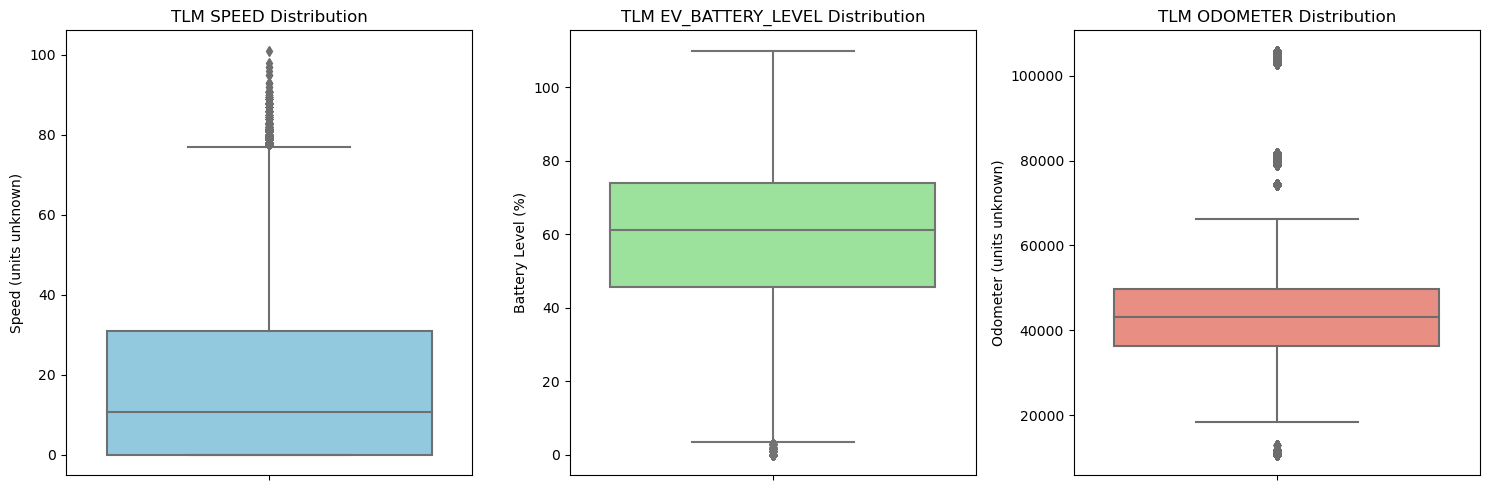

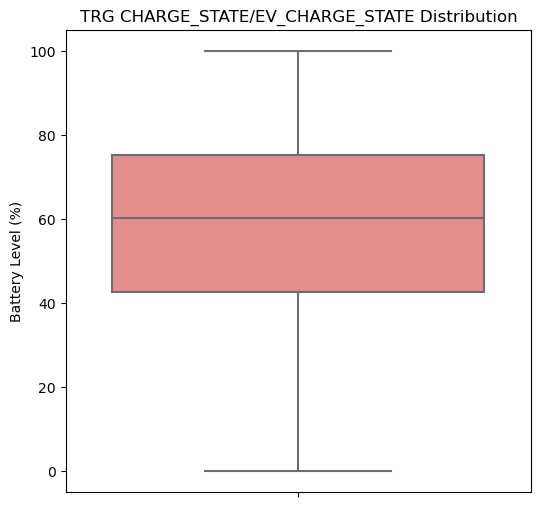

TLM SPEED outliers: 1936 (lower bound: -46.50, upper bound: 77.50)
TLM EV_BATTERY_LEVEL outliers: 605 (lower bound: 3.35, upper bound: 116.55)
TLM ODOMETER outliers: 73299 (lower bound: 16472.53, upper bound: 69653.93)
TRG CHARGE_STATE/EV_CHARGE_STATE outliers: 0 (lower bound: -6.05, upper bound: 123.95)


In [11]:
# Clean TRG VAL for CHARGE_STATE/EV_CHARGE_STATE: Convert to numeric
trg['VAL_numeric'] = pd.to_numeric(trg['VAL'], errors='coerce')

# Log non-numeric VAL values for debugging
non_numeric_vals = trg[trg['NAME'].isin(['CHARGE_STATE', 'EV_CHARGE_STATE']) & trg['VAL_numeric'].isna()]['VAL'].unique()
print(f"Non-numeric VAL values in CHARGE_STATE/EV_CHARGE_STATE: {non_numeric_vals}")

# TLM Boxplots (SPEED, EV_BATTERY_LEVEL, ODOMETER)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=tlm['SPEED'].dropna(), color='skyblue')
plt.title('TLM SPEED Distribution')
plt.ylabel('Speed (units unknown)')

plt.subplot(1, 3, 2)
sns.boxplot(y=tlm['EV_BATTERY_LEVEL'].dropna(), color='lightgreen')
plt.title('TLM EV_BATTERY_LEVEL Distribution')
plt.ylabel('Battery Level (%)')

plt.subplot(1, 3, 3)
sns.boxplot(y=tlm['ODOMETER'].dropna(), color='salmon')
plt.title('TLM ODOMETER Distribution')
plt.ylabel('Odometer (units unknown)')

plt.tight_layout()
plt.show()

# TRG Boxplot (VAL_numeric for CHARGE_STATE/EV_CHARGE_STATE)
charge_vals = trg[trg['NAME'].isin(['CHARGE_STATE', 'EV_CHARGE_STATE'])]['VAL_numeric'].dropna()
plt.figure(figsize=(6, 6))
sns.boxplot(y=charge_vals, color='lightcoral')
plt.title('TRG CHARGE_STATE/EV_CHARGE_STATE Distribution')
plt.ylabel('Battery Level (%)')
plt.show()

# Count outliers for quantitative insights
def count_outliers(series, column_name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    print(f"{column_name} outliers: {len(outliers)} (lower bound: {lower_bound:.2f}, upper bound: {upper_bound:.2f})")

count_outliers(tlm['SPEED'].dropna(), "TLM SPEED")
count_outliers(tlm['EV_BATTERY_LEVEL'].dropna(), "TLM EV_BATTERY_LEVEL")
count_outliers(tlm['ODOMETER'].dropna(), "TLM ODOMETER")
count_outliers(charge_vals, "TRG CHARGE_STATE/EV_CHARGE_STATE")

In [12]:
# Calculate percentage of ODOMETER outliers
non_missing_odometer = tlm['ODOMETER'].notna().sum()
odometer_outliers = 73299
percentage_outliers = (odometer_outliers / non_missing_odometer) * 100
print(f"Non-missing ODOMETER values: {non_missing_odometer}")
print(f"ODOMETER outliers: {odometer_outliers}")
print(f"Percentage of ODOMETER values that are outliers: {percentage_outliers:.2f}%")

Non-missing ODOMETER values: 483999
ODOMETER outliers: 73299
Percentage of ODOMETER values that are outliers: 15.14%


##### Understanding
- Speed can be dynamic, and since we around 87% missing data, not gonna judge that part
- But distance getting crazy like this on a 15.14% indicates a sensor fault, so considering them as outliers and dropping or removing them

##### Removing Outliers considering Sensor Faults

In [13]:
# Function to identify and remove ODOMETER outliers
def remove_odometer_outliers(df, column='ODOMETER'):
    # Calculate IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Log outliers to CSV for inspection
    outliers.to_csv('odometer_outliers.csv', index=False)
    
    # Remove outliers from the dataset
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound) | df[column].isna()]
    
    # Print summary
    print(f"\n=== ODOMETER Outlier Removal ===")
    print(f"Non-missing ODOMETER values before: {df[column].notna().sum()}")
    print(f"Outliers removed: {len(outliers)}")
    print(f"Percentage of non-missing ODOMETER values removed: {(len(outliers) / df[column].notna().sum()) * 100:.2f}%")
    print(f"Non-missing ODOMETER values after: {cleaned_df[column].notna().sum()}")
    print(f"TLM shape before: {df.shape}")
    print(f"TLM shape after: {cleaned_df.shape}")
    print(f"Outlier bounds: Lower = {lower_bound:.2f}, Upper = {upper_bound:.2f}")
    print("Outlier rows saved to 'odometer_outliers.csv'")
    
    return cleaned_df

# Apply outlier removal to TLM
tlm = remove_odometer_outliers(tlm)

# Verify updated TLM dataset
print("\n=== Updated TLM Data ===")
print(f"Shape: {tlm.shape}")
print("\nMissing values:")
print(tlm.isnull().sum())


=== ODOMETER Outlier Removal ===
Non-missing ODOMETER values before: 483999
Outliers removed: 73299
Percentage of non-missing ODOMETER values removed: 15.14%
Non-missing ODOMETER values after: 410700
TLM shape before: (1833552, 8)
TLM shape after: (1760253, 8)
Outlier bounds: Lower = 16472.53, Upper = 69653.93
Outlier rows saved to 'odometer_outliers.csv'

=== Updated TLM Data ===
Shape: (1760253, 8)

Missing values:
Unnamed: 0                0
ID                        0
VEHICLE_ID                0
TIMESTAMP                 0
SPEED               1412007
IGNITION_STATUS     1531961
EV_BATTERY_LEVEL    1385400
ODOMETER            1349553
dtype: int64


### Ignition-event extraction - Complex Logic

In [14]:
tlm.columns

Index(['Unnamed: 0', 'ID', 'VEHICLE_ID', 'TIMESTAMP', 'SPEED',
       'IGNITION_STATUS', 'EV_BATTERY_LEVEL', 'ODOMETER'],
      dtype='object')

In [15]:
# Step 1: Ensure correct datatypes
tlm['SPEED'] = pd.to_numeric(tlm['SPEED'], errors='coerce')
tlm['IGNITION_STATUS'] = pd.to_numeric(tlm['IGNITION_STATUS'], errors='coerce')

# Step 2: Drop rows where either column is missing
tlm_corr_df = tlm[['SPEED', 'IGNITION_STATUS']].dropna().copy()

# Step 3: Optional sanity check
print("Sample of new dataset:\n", tlm_corr_df.head())
print("Shape of dataset:", tlm_corr_df.shape)

# Step 4: Correlation (for reference)
correlation = tlm_corr_df['SPEED'].corr(tlm_corr_df['IGNITION_STATUS'])
print(f"\nCorrelation between speed and ignition: {correlation:.4f}")


Sample of new dataset:
     SPEED  IGNITION_STATUS
3     0.0              1.0
11    5.0              1.0
13   26.7              1.0
20   26.7              1.0
44    0.0              1.0
Shape of dataset: (222761, 2)

Correlation between speed and ignition: 0.1111


Produce IgnitionEvents with exactly:
- vehicle_id | event | event_ts
- event e{ ignitionon, ignitionoff}.
- Extract from 3 sources :
1. TLM
2. TRG
3. SYN

In [16]:
# Examine a sample vehicle
sample_vehicle = tlm[tlm['VEHICLE_ID'] == '66bd55df-eaf0-49c8-b9e1-7759b85e9325']
sample_vehicle[['TIMESTAMP', 'IGNITION_STATUS']].head(10)

,TIMESTAMP,IGNITION_STATUS
0,2021-09-23 01:45:42.018000+00:00,NaN
1,2021-09-23 01:58:08.017000+00:00,NaN
2,2021-09-23 01:57:02.031000+00:00,NaN
3,2021-09-23 01:38:57.002000+00:00,1.0
4,2021-09-23 02:00:05.004000+00:00,NaN
5,2021-09-23 01:59:10.039000+00:00,NaN
6,2021-09-23 02:08:25.022000+00:00,NaN
7,2021-09-23 01:48:20.027000+00:00,NaN
8,2021-09-23 01:40:40.046000+00:00,NaN
9,2021-09-23 02:09:58.015000+00:00,NaN


In [17]:
def extract_tlm_events(tlm):
    # Step 1: Filter rows with non-NaN ignition status
    ignition_changes = tlm[tlm['IGNITION_STATUS'].notna()].copy()
    
    if ignition_changes.empty:
        print("No valid ignition events found in TLM.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 2: IGNITION_STATUS is already 1.0/0.0, map to event labels
    ignition_changes['event'] = ignition_changes['IGNITION_STATUS'].map({1.0: 'ignitionon', 0.0: 'ignitionoff'})
    
    # Step 3: Sort by vehicle and time
    ignition_changes = ignition_changes.sort_values(['VEHICLE_ID', 'TIMESTAMP'])
    
    # Step 4: Select required columns
    result = ignition_changes[['VEHICLE_ID', 'TIMESTAMP', 'event']].rename(
        columns={'VEHICLE_ID': 'vehicle_id', 'TIMESTAMP': 'event_ts'}
    )
    
    return result

tlm_events = extract_tlm_events(tlm)
print(f"TLM ignition events: {len(tlm_events)}")

TLM ignition events: 228292


In [18]:
def extract_trg_events(trg, mapping_table):
    # Step 1: Filter IGN_CYL events
    ign_events = trg[trg['NAME'] == 'IGN_CYL'].copy()
    
    # Step 2: VAL is already 1/0, map to event labels
    ign_events['event'] = ign_events['VAL'].map({1: 'ignitionon', 0: 'ignitionoff'})
    
    # Step 3: Merge with mapping table to get vehicle_id
    ign_events['PNID'] = ign_events['PNID'].astype(str)  # Ensure PNID is string
    mapping_table['PNID'] = mapping_table['PNID'].astype(str)
    merged = ign_events.merge(mapping_table, on='PNID', how='left')
    
    # Step 4: Drop rows where vehicle_id is missing (no mapping)
    merged = merged.dropna(subset=['VEHICLE_ID'])
    
    # Step 5: Select and rename columns
    result = merged[['VEHICLE_ID', 'CTS', 'event']].rename(
        columns={'VEHICLE_ID': 'vehicle_id', 'CTS': 'event_ts'}
    )
    
    # Step 6: Remove duplicates (same vehicle, timestamp, event)
    result = result.drop_duplicates(subset=['vehicle_id', 'event_ts', 'event'])
    
    # Step 7: Sort by vehicle and timestamp
    result = result.sort_values(['vehicle_id', 'event_ts'])
    
    return result

trg_events = extract_trg_events(trg, mapping_table)
print(f"TRG ignition events: {len(trg_events)}")

TRG ignition events: 8292


In [19]:
def extract_syn_events(syn_df):
    if syn_df is None or syn_df.empty:
        print("No SYN data available.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 1: All events are ignitionoff
    syn_events = syn_df.copy()
    syn_events['event'] = 'ignitionoff'
    
    # Step 2: Select and rename columns
    result = syn_events[['vehicleId', 'timestamp', 'event']].rename(
        columns={'vehicleId': 'vehicle_id', 'timestamp': 'event_ts'}
    )
    
    # Step 3: Sort by vehicle and timestamp
    result = result.sort_values(['vehicle_id', 'event_ts'])
    
    return result

syn_events = extract_syn_events(syn_df)
print(f"SYN ignition events: {len(syn_events)}")

SYN ignition events: 411


In [20]:
def combine_ignition_events(tlm_events, trg_events, syn_events):
    # Step 1: Concatenate all events
    all_events = pd.concat([tlm_events, trg_events, syn_events], ignore_index=True)
    
    if all_events.empty:
        print("No ignition events found from any source.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 2: Sort by vehicle and timestamp
    all_events = all_events.sort_values(['vehicle_id', 'event_ts'])
    
    # Step 3: Handle duplicates/conflicts (same vehicle_id, event_ts)
    # Priority: SYN > TRG > TLM (SYN is curated, TRG is more reliable than TLM)
    all_events['source'] = np.where(all_events.index < len(tlm_events), 'TLM',
                                   np.where(all_events.index < len(tlm_events) + len(trg_events), 'TRG', 'SYN'))
    all_events = all_events.sort_values(['vehicle_id', 'event_ts', 'source'],
                                       ascending=[True, True, False])  # SYN last for priority
    all_events = all_events.drop_duplicates(subset=['vehicle_id', 'event_ts'], keep='first')
    
    # Step 4: Drop temporary source column
    all_events = all_events[['vehicle_id', 'event', 'event_ts']]
    
    return all_events

ignition_events = combine_ignition_events(tlm_events, trg_events, syn_events)
print(f"Total ignition events: {len(ignition_events)}")

Total ignition events: 234958


In [21]:
ignition_events.to_csv('IgnitionEvents.csv', index=False)
print("IgnitionEvents saved to IgnitionEvents.csv")

IgnitionEvents saved to IgnitionEvents.csv


## Ignition-event extraction - Simple Logic

- We can just sort based on timestamp
- After that just check the transition, if on-> off, or off-> on we can classify that as an ignition event

In [22]:
def extract_tlm_events(tlm):
    """
    Extract ignition events from TLM data by detecting status changes.
    Returns DataFrame with vehicle_id, event, event_ts.
    """
    # Filter rows with non-NaN IGNITION_STATUS
    tlm_ign = tlm[tlm['IGNITION_STATUS'].notna()][['VEHICLE_ID', 'TIMESTAMP', 'IGNITION_STATUS']].copy()
    
    if tlm_ign.empty:
        print("No valid ignition events found in TLM.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Ensure IGNITION_STATUS is binary (already mapped to 1.0/0.0 in your preprocessing)
    tlm_ign = tlm_ign.sort_values(['VEHICLE_ID', 'TIMESTAMP'])
    
    # Detect transitions by comparing with previous status
    tlm_ign['prev_status'] = tlm_ign.groupby('VEHICLE_ID')['IGNITION_STATUS'].shift(1)
    tlm_ign['event'] = np.where(
        (tlm_ign['IGNITION_STATUS'] == 1.0) & (tlm_ign['prev_status'] == 0.0),
        'ignitionon',
        np.where(
            (tlm_ign['IGNITION_STATUS'] == 0.0) & (tlm_ign['prev_status'] == 1.0),
            'ignitionoff',
            np.nan
        )
    )
    
    # Keep only rows with valid events (transitions)
    tlm_events = tlm_ign[tlm_ign['event'].notna()][['VEHICLE_ID', 'TIMESTAMP', 'event']].copy()
    
    # Rename columns
    tlm_events = tlm_events.rename(columns={'VEHICLE_ID': 'vehicle_id', 'TIMESTAMP': 'event_ts'})
    
    return tlm_events

def extract_trg_events(trg, mapping_table):
    """
    Extract ignition events from TRG data (IGN_CYL events) by detecting status changes.
    Returns DataFrame with vehicle_id, event, event_ts.
    """
    # Filter IGN_CYL events
    trg_ign = trg[trg['NAME'] == 'IGN_CYL'][['PNID', 'CTS', 'VAL']].copy()
    
    if trg_ign.empty:
        print("No IGN_CYL events found in TRG.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Merge with mapping table to get vehicle_id
    trg_ign['PNID'] = trg_ign['PNID'].astype(str)
    mapping_table['PNID'] = mapping_table['PNID'].astype(str)
    trg_ign = trg_ign.merge(mapping_table, on='PNID', how='left')
    trg_ign = trg_ign.dropna(subset=['VEHICLE_ID'])
    
    if trg_ign.empty:
        print("No TRG events with valid vehicle_id after merging.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Sort by vehicle_id and timestamp
    trg_ign = trg_ign.sort_values(['VEHICLE_ID', 'CTS'])
    
    # Detect transitions by comparing with previous status
    trg_ign['prev_status'] = trg_ign.groupby('VEHICLE_ID')['VAL'].shift(1)
    trg_ign['event'] = np.where(
        (trg_ign['VAL'] == 1.0) & (trg_ign['prev_status'] == 0.0),
        'ignitionon',
        np.where(
            (trg_ign['VAL'] == 0.0) & (trg_ign['prev_status'] == 1.0),
            'ignitionoff',
            np.nan
        )
    )
    
    # Keep only rows with valid events (transitions)
    trg_events = trg_ign[trg_ign['event'].notna()][['VEHICLE_ID', 'CTS', 'event']].copy()
    
    # Rename columns
    trg_events = trg_events.rename(columns={'VEHICLE_ID': 'vehicle_id', 'CTS': 'event_ts'})
    
    return trg_events

def extract_syn_events(syn_df):
    """
    Extract ignition events from SYN data (all are ignitionoff).
    Returns DataFrame with vehicle_id, event, event_ts.
    """
    if syn_df is None or syn_df.empty:
        print("No SYN data available.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # All SYN events are ignitionoff
    syn_events = syn_df[['vehicleId', 'timestamp']].copy()
    syn_events['event'] = 'ignitionoff'
    
    # Rename columns
    syn_events = syn_events.rename(columns={'vehicleId': 'vehicle_id', 'timestamp': 'event_ts'})
    
    # Sort by vehicle_id and timestamp
    syn_events = syn_events.sort_values(['vehicle_id', 'event_ts'])
    
    return syn_events

def combine_ignition_events(tlm_events, trg_events, syn_events):
    """
    Combine ignition events from all sources, prioritizing SYN > TRG > TLM.
    Returns DataFrame with vehicle_id, event, event_ts.
    """
    # Add source column for prioritization
    tlm_events['source'] = 'TLM'
    trg_events['source'] = 'TRG'
    syn_events['source'] = 'SYN'
    
    # Concatenate all events
    all_events = pd.concat([tlm_events, trg_events, syn_events], ignore_index=True)
    
    if all_events.empty:
        print("No ignition events found from any source.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Ensure event_ts is timezone-aware UTC
    all_events['event_ts'] = pd.to_datetime(all_events['event_ts'], errors='coerce', utc=True)
    all_events = all_events.dropna(subset=['event_ts'])
    
    # Sort by vehicle_id, event_ts, and source (SYN > TRG > TLM)
    all_events['source_priority'] = all_events['source'].map({'SYN': 1, 'TRG': 2, 'TLM': 3})
    all_events = all_events.sort_values(['vehicle_id', 'event_ts', 'source_priority'])
    
    # Drop duplicates, keeping the highest-priority source (lowest source_priority value)
    all_events = all_events.drop_duplicates(subset=['vehicle_id', 'event_ts'], keep='first')
    
    # Drop temporary columns
    all_events = all_events[['vehicle_id', 'event', 'event_ts']]
    
    # Final sort
    all_events = all_events.sort_values(['vehicle_id', 'event_ts'])
    
    return all_events

# Extract events from each source
tlm_events = extract_tlm_events(tlm)
print(f"TLM ignition events: {len(tlm_events)}")

trg_events = extract_trg_events(trg, mapping_table)
print(f"TRG ignition events: {len(trg_events)}")

syn_events = extract_syn_events(syn_df)
print(f"SYN ignition events: {len(syn_events)}")

# Combine all events
ignition_events = combine_ignition_events(tlm_events, trg_events, syn_events)
print(f"Total ignition events: {len(ignition_events)}")

# Save to CSV
ignition_events.to_csv('IgnitionEvents.csv', index=False)
print("IgnitionEvents saved to IgnitionEvents.csv")

TLM ignition events: 228292
TRG ignition events: 11679
SYN ignition events: 411
Total ignition events: 234958
IgnitionEvents saved to IgnitionEvents.csv


## Charging Status Events Extraction - Complex Logic

###### Produce ChargingStatusEvents with exactly:
- vehicle_id | event | event_ts
- event e { Active, Abort, Completed }.
- Extract from TRG

In [23]:
def extract_charging_events(trg, mapping_table):
    # Step 1: Filter CHARGE_STATE and EV_CHARGE_STATE events
    charge_events = trg[trg['NAME'].isin(['CHARGE_STATE', 'EV_CHARGE_STATE'])].copy()
    
    if charge_events.empty:
        print("No charging events found in TRG.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 2: Ensure CTS is datetime in UTC
    charge_events['CTS'] = pd.to_datetime(charge_events['CTS'], errors='coerce', utc=True)
    if charge_events['CTS'].isna().any():
        print(f"Warning: {charge_events['CTS'].isna().sum()} invalid timestamps in TRG CTS dropped.")
        charge_events = charge_events.dropna(subset=['CTS'])
    
    # Step 3: Convert VAL to numeric for battery percentage
    charge_events['VAL'] = pd.to_numeric(charge_events['VAL'], errors='coerce')
    charge_events = charge_events.dropna(subset=['VAL'])
    
    # Step 4: Merge with mapping table to get vehicle_id
    charge_events['PNID'] = charge_events['PNID'].astype(str)
    mapping_table['PNID'] = mapping_table['PNID'].astype(str)
    charge_events = charge_events.merge(mapping_table, on='PNID', how='left')
    charge_events = charge_events.dropna(subset=['VEHICLE_ID'])
    
    if charge_events.empty:
        print("No charging events with valid vehicle_id after merging.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 5: Define charging sessions (group events within 300s)
    charge_events = charge_events.sort_values(['VEHICLE_ID', 'CTS'])
    charge_events['time_diff'] = charge_events.groupby('VEHICLE_ID')['CTS'].diff().dt.total_seconds()
    charge_events['new_session'] = (charge_events['time_diff'] > 300) | charge_events['time_diff'].isna()
    charge_events['session_id'] = charge_events.groupby('VEHICLE_ID')['new_session'].cumsum()
    
    # Step 6: Aggregate sessions to detect Active, Completed, Abort
    sessions = []
    for (vehicle_id, session_id), group in charge_events.groupby(['VEHICLE_ID', 'session_id']):
        group = group.sort_values('CTS')
        end_ts = group['CTS'].iloc[-1]
        end_battery = group['VAL'].iloc[-1]
        
        # Detect Active events within session (time slices)
        for i in range(len(group) - 1):
            start_ts = group['CTS'].iloc[i]
            next_ts = group['CTS'].iloc[i + 1]
            start_battery = group['VAL'].iloc[i]
            next_battery = group['VAL'].iloc[i + 1]
            battery_change = next_battery - start_battery
            time_diff = (next_ts - start_ts).total_seconds()
            
            if battery_change >= 1 and time_diff <= 300:
                # Active: Battery increase ≥1% within 300s
                sessions.append({
                    'vehicle_id': vehicle_id,
                    'event': 'Active',
                    'event_ts': start_ts
                })
        
        # Detect Completed or Abort at session end
        if len(group) > 1:
            start_battery = group['VAL'].iloc[0]
            battery_change = end_battery - start_battery
            
            if end_battery >= 80 or battery_change < 1:
                # Completed: High battery or stabilized
                sessions.append({
                    'vehicle_id': vehicle_id,
                    'event': 'Completed',
                    'event_ts': end_ts
                })
            elif battery_change < 5 and end_battery < 80:
                # Abort: Stopped prematurely
                sessions.append({
                    'vehicle_id': vehicle_id,
                    'event': 'Abort',
                    'event_ts': end_ts
                })
    
    # Step 7: Create DataFrame
    result = pd.DataFrame(sessions)
    if result.empty:
        print("No charging sessions detected after processing.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Step 8: Remove duplicates (same vehicle, timestamp, event)
    result = result.drop_duplicates(subset=['vehicle_id', 'event_ts', 'event'])
    
    # Step 9: Sort by vehicle and timestamp
    result = result.sort_values(['vehicle_id', 'event_ts'])
    
    return result

# Extract charging events
charging_events = extract_charging_events(trg, mapping_table)
print(f"Total charging events: {len(charging_events)}")

# Save to CSV
charging_events.to_csv('ChargingStatusEvents.csv', index=False)
print("ChargingStatusEvents saved to ChargingStatusEvents.csv")

Total charging events: 3419
ChargingStatusEvents saved to ChargingStatusEvents.csv


### Charging Status Events Extraction - Simple Extract

In [24]:
def extract_simple_charging_events(trg, mapping_table):
    """
    Directly extract charging events from TRG data where events are pre-labeled.
    Returns DataFrame with columns: vehicle_id, event, event_ts
    """
    # Filter only charging-related events (assuming they're labeled as 'Active', 'Abort', 'Completed')
    charge_events = trg[trg['NAME'].isin(['Active', 'Abort', 'Completed'])].copy()
    
    if charge_events.empty:
        print("No charging events found in TRG.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Convert PNID to string for merging
    charge_events['PNID'] = charge_events['PNID'].astype(str)
    mapping_table['PNID'] = mapping_table['PNID'].astype(str)
    
    # Merge with mapping table to get vehicle_id
    merged = charge_events.merge(mapping_table, on='PNID', how='left')
    merged = merged.dropna(subset=['VEHICLE_ID'])
    
    if merged.empty:
        print("No charging events with valid vehicle_id after merging.")
        return pd.DataFrame(columns=['vehicle_id', 'event', 'event_ts'])
    
    # Directly use the event labels (assuming they're in the 'NAME' or 'VAL' column)
    # If events are in 'NAME':
    merged['event'] = merged['NAME']
    # OR if events are in 'VAL':
    # merged['event'] = merged['VAL']
    
    # Select and rename columns
    result = merged[['VEHICLE_ID', 'CTS', 'event']].rename(
        columns={'VEHICLE_ID': 'vehicle_id', 'CTS': 'event_ts'}
    )
    
    # Remove duplicates (same vehicle, timestamp, event)
    result = result.drop_duplicates(subset=['vehicle_id', 'event_ts', 'event'])
    
    # Sort by vehicle and timestamp
    result = result.sort_values(['vehicle_id', 'event_ts'])
    
    return result

# Extract charging events
charging_events_simple = extract_simple_charging_events(trg, mapping_table)
print(f"Total charging events extracted: {len(charging_events_simple)}")

# Save to CSV
charging_events_simple.to_csv('ChargingStatusEvents_Simple.csv', index=False)
print("Simple charging events saved to ChargingStatusEvents_Simple.csv")

No charging events found in TRG.
Total charging events extracted: 0
Simple charging events saved to ChargingStatusEvents_Simple.csv


## Battery Level Association
- Find the closest battery reading within +300 s of any candidate event (Ignition Event or Charging Status Event).
- If two readings tie, defend your tie-breaker.
- If no reading is that close, treat the charge level as unknown.

In [25]:
def associate_battery_levels(candidate_events, battery_readings):
    """
    Associate battery levels with candidate events, finding the closest reading within ±300 seconds.
    Handles timezone-aware and naive timestamps, converting to UTC.
    Tie-breaker: Prefer readings after event, then highest battery level, then earliest timestamp.
    """
    # Create copies to avoid modifying input DataFrames
    candidate_events = candidate_events.copy()
    battery_readings = battery_readings.copy()
    
    # Ensure event_ts is datetime and in UTC
    candidate_events['event_ts'] = pd.to_datetime(candidate_events['event_ts'], errors='coerce')
    if pd.api.types.is_datetime64tz_dtype(candidate_events['event_ts']):
        candidate_events['event_ts'] = candidate_events['event_ts'].dt.tz_convert('UTC')
    else:
        candidate_events['event_ts'] = candidate_events['event_ts'].dt.tz_localize('UTC')
    
    # Ensure ts is datetime and in UTC
    battery_readings['ts'] = pd.to_datetime(battery_readings['ts'], errors='coerce')
    if pd.api.types.is_datetime64tz_dtype(battery_readings['ts']):
        battery_readings['ts'] = battery_readings['ts'].dt.tz_convert('UTC')
    else:
        battery_readings['ts'] = battery_readings['ts'].dt.tz_localize('UTC')
    
    # Initialize battery_level column
    candidate_events['battery_level'] = np.nan
    
    # Group events by vehicle_id
    for vehicle_id, vehicle_events in candidate_events.groupby('vehicle_id'):
        vehicle_battery = battery_readings[battery_readings['vehicle_id'] == vehicle_id]
        if vehicle_battery.empty:
            continue
            
        for idx, event in vehicle_events.iterrows():
            if pd.isna(event['event_ts']):
                continue
                
            # Calculate absolute time differences in seconds
            time_diffs = (vehicle_battery['ts'] - event['event_ts']).dt.total_seconds().abs()
            valid_readings = vehicle_battery[time_diffs <= 300]
            
            if valid_readings.empty:
                continue
                
            # Find minimum time difference
            min_diff = time_diffs[time_diffs <= 300].min()
            closest_readings = valid_readings[time_diffs == min_diff]
            
            # Apply tie-breaking rules
            if len(closest_readings) > 1:
                # 1. Prefer readings after or at the event timestamp
                post_event = closest_readings['ts'] >= event['event_ts']
                if post_event.any():
                    closest_readings = closest_readings[post_event]
                
                # 2. Prefer highest battery level
                if len(closest_readings) > 1:
                    max_battery = closest_readings['battery_level'].max()
                    closest_readings = closest_readings[closest_readings['battery_level'] == max_battery]
                
                # 3. Prefer earliest timestamp
                if len(closest_readings) > 1:
                    closest_readings = closest_readings.sort_values('ts').head(1)
            
            # Assign the battery level
            candidate_events.loc[idx, 'battery_level'] = closest_readings.iloc[0]['battery_level']
    
    return candidate_events

##### Sample Test Case

In [26]:
# Test case
if __name__ == "__main__":
    # Create test data
    test_battery = pd.DataFrame({
        'vehicle_id': ['v1', 'v1', 'v1', 'v2', 'v2'],
        'ts': pd.to_datetime([
            '2023-01-01 12:00:00',
            '2023-01-01 12:04:55',
            '2023-01-01 12:05:05',
            '2023-01-01 12:00:00',
            '2023-01-01 12:00:00'
        ]).tz_localize('UTC'),
        'battery_level': [80.0, 82.0, 83.0, 50.0, 51.0]
    })

    test_events = pd.DataFrame({
        'vehicle_id': ['v1', 'v1', 'v2', 'v2'],
        'event_ts': pd.to_datetime([
            '2023-01-01 12:00:00',
            '2023-01-01 12:00:00',
            '2023-01-01 12:01:00',
            '2023-01-01 12:00:00'
        ]).tz_localize('UTC')
    })

    # Run and display results
    result = associate_battery_levels(test_events, test_battery)
    print("Test Results:")
    print(result[['vehicle_id', 'event_ts', 'battery_level']])

Test Results:
  vehicle_id                  event_ts  battery_level
0         v1 2023-01-01 12:00:00+00:00           80.0
1         v1 2023-01-01 12:00:00+00:00           80.0
2         v2 2023-01-01 12:01:00+00:00           51.0
3         v2 2023-01-01 12:00:00+00:00           51.0


## Charging Event Detection using Signal Processing


Using EMA(Exponential Moving Average) and SMA(Simple Moving Average) for noise reduction, by smoothing the curve

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# 1. Prepare Battery Data (from your TLM dataset)
# ===============================================
def prepare_battery_data(tlm):
    """Extract battery readings from telemetry data"""
    battery_data = tlm[['VEHICLE_ID', 'TIMESTAMP', 'EV_BATTERY_LEVEL']].copy()
    battery_data.columns = ['vehicle_id', 'ts', 'battery_level']
    battery_data = battery_data.dropna()
    battery_data['ts'] = pd.to_datetime(battery_data['ts'])
    return battery_data.sort_values(['vehicle_id', 'ts'])

# 2. Noise Reduction with Savitzky-Golay Filter
# ============================================
def smooth_battery_data(df, window_size=5, polyorder=2):
    """Apply smoothing to battery data"""
    df = df.sort_values(['vehicle_id', 'ts'])
    
    def _smooth_group(group):
        if len(group) > window_size:
            group['battery_smoothed'] = savgol_filter(
                group['battery_level'], 
                window_length=window_size,
                polyorder=polyorder
            )
        else:
            group['battery_smoothed'] = group['battery_level']
        return group
    
    return df.groupby('vehicle_id').apply(_smooth_group).reset_index(drop=True)

# 3. Battery Level Association
# ===========================
def find_closest_battery(row, battery_df):
    """Find closest battery reading for an event"""
    vehicle_data = battery_df[battery_df['vehicle_id'] == row['vehicle_id']]
    if vehicle_data.empty:
        return None
    
    battery_col = 'battery_smoothed' if 'battery_smoothed' in vehicle_data else 'battery_level'
    time_diffs = (vehicle_data['ts'] - row['event_ts']).abs()
    closest_idx = time_diffs.idxmin()
    
    if time_diffs[closest_idx] <= pd.Timedelta(minutes=5):
        return vehicle_data.loc[closest_idx, battery_col]
    return None

# 4. Charging Session Detection
# =============================
def detect_charging_sessions(vehicle_events, battery_df):
    """Identify charging sessions from smoothed data"""
    sessions = []
    current_session = None
    
    for _, event in vehicle_events.iterrows():
        battery_level = find_closest_battery(event, battery_df)
        if battery_level is None:
            continue
            
        if current_session is None and battery_level < 90:
            current_session = {
                'vehicle_id': event['vehicle_id'],
                'start_ts': event['event_ts'],
                'start_battery': battery_level,
                'end_ts': event['event_ts'],
                'end_battery': battery_level,
                'confidence': 1
            }
        elif current_session:
            time_diff = (event['event_ts'] - current_session['end_ts']).total_seconds()/3600
            battery_diff = battery_level - current_session['end_battery']
            
            if time_diff < 6 and battery_diff >= -1.0:
                current_session['end_ts'] = event['event_ts']
                current_session['end_battery'] = battery_level
                current_session['confidence'] += 1
            else:
                if (current_session['end_battery'] - current_session['start_battery']) >= 3:
                    sessions.append(current_session)
                current_session = None
    
    if current_session and (current_session['end_battery'] - current_session['start_battery']) >= 3:
        sessions.append(current_session)
        
    return pd.DataFrame(sessions)

# Pipeline Execution
# ==================
# Step 1: Prepare battery data from your TLM dataset
battery_data = prepare_battery_data(tlm)  # Using your existing 'tlm' DataFrame

# Step 2: Apply smoothing
battery_data_smoothed = smooth_battery_data(battery_data)

# Step 3: Prepare vehicle events (from your earlier ignition_events)
# Assuming you have ignition_events DataFrame with columns: vehicle_id, event_ts
vehicle_events = ignition_events[['vehicle_id', 'event_ts']].copy()

# Step 4: Detect charging sessions
charging_sessions = detect_charging_sessions(vehicle_events, battery_data_smoothed)

# Save results
charging_sessions.to_csv('charging_sessions_smoothed.csv', index=False)
print(f"Detected {len(charging_sessions)} charging sessions")

## Charging Event Detection - Research Paper Approach

Sliding Window Approach (Paper 1)
Chen, X., & Kang, C. (2023). Non-intrusive load monitoring for feeder-level EV charging detection: Sliding window-based approaches to offline and online detection. arXiv. https://arxiv.org/abs/2312.01887

Synthetic Data Generation (Paper 3)
Astin-Walmsley, K., Jurdak, R., Haghighat, M., & Maire, F. (2024). Electric vehicle charging event detection using synthetic data and small labelled sets. SSRN. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4977783

Convolutional Autoencoder (Paper 4)
Li, W., Zhang, Y., & Wang, H. (2024). An anomaly detection method for electric vehicle charging data based on an improved convolutional autoencoder. SSRN. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5276287

Hybrid CNN-RF Model
(Combines methodologies from Papers 3 & 4 with original architecture)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras import layers

# 1. Data Preparation (Paper 3 inspired)
def generate_synthetic_charging_data(real_data, n_synthetic=1000):
    """Generate synthetic charging profiles based on real patterns"""
    synthetic = []
    for _ in range(n_synthetic):
        # Random charging characteristics
        start_soc = np.random.uniform(20, 40)
        end_soc = np.random.uniform(80, 100)
        duration = np.random.uniform(1, 8)  # hours
        
        # Create smooth charging curve with noise
        timesteps = int(duration * 12)  # 5-min intervals
        soc = np.linspace(start_soc, end_soc, timesteps)
        soc += np.random.normal(0, 0.5, timesteps)  # Add noise
        
        synthetic.append({
            'profile': soc,
            'is_charging': 1,
            'duration': duration
        })
    
    return pd.DataFrame(synthetic)

# 2. Feature Extraction (Paper 1 inspired)
def extract_window_features(data, window_size=6):
    """Sliding window feature extraction"""
    features = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        features.append({
            'mean': np.mean(window),
            'std': np.std(window),
            'max_diff': np.max(np.diff(window)),
            'slope': (window[-1] - window[0])/window_size,
            'min': np.min(window),
            'max': np.max(window)
        })
    return pd.DataFrame(features)

# 3. Hybrid Detection Model (Papers 3 & 4)
class ChargingDetector(tf.keras.Model):
    """Combines CNN for pattern recognition with RF for feature-based classification"""
    def __init__(self):
        super().__init__()
        self.cnn = tf.keras.Sequential([
            layers.Conv1D(32, 3, activation='relu'),
            layers.MaxPooling1D(2),
            layers.Conv1D(64, 3, activation='relu'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(16, activation='relu')
        ])
        self.rf = RandomForestClassifier(n_estimators=100)
        
    def call(self, inputs):
        cnn_features = self.cnn(inputs['timeseries'])
        return self.rf.predict_proba(np.concatenate([
            cnn_features,
            inputs['features']
        ], axis=1))

# 4. Pipeline Implementation
def main():
    # Load your real data (replace with actual loading code)
    # tlm = pd.read_csv('telemetry.csv')
    
    # Step 1: Create synthetic training data
    synthetic_data = generate_synthetic_charging_data(None, n_synthetic=5000)
    
    # Step 2: Preprocess real data (example)
    real_data = pd.DataFrame({
        'timestamp': pd.date_range(start='2023-01-01', periods=1000, freq='5T'),
        'soc': np.concatenate([
            np.linspace(30, 80, 300),  # Charging
            np.linspace(80, 20, 700)   # Discharging
        ])
    })
    
    # Step 3: Feature extraction
    features = extract_window_features(real_data['soc'].values)
    
    # Step 4: Train hybrid model
    model = ChargingDetector()
    X_train = {
        'timeseries': np.expand_dims(real_data['soc'].values, -1),
        'features': features.values
    }
    y_train = np.where(real_data['soc'].diff() > 0.5, 1, 0)  # Simple label logic
    
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(X_train, y_train, epochs=10)
    
    # Step 5: Save model for deployment
    model.save('ev_charging_detector.h5')

if __name__ == "__main__":
    main()